<a href="https://colab.research.google.com/github/yalexie1/Data-Science/blob/main/Unit9/YaleXie_Unit9Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 9 Project

## Part I: Introduction

For my Unit 9 project, I will use a neural network to create a model that relates MKT to Walmart's yearly stock price change. From my previous project (Unit 8 Project), we have confirmed that the MKT factor is by far the most important factor that determines stock price movement. Now, I want to use a neural network to plot those two against each other in the context of Walmart.

In [87]:
import torch
import numpy as np
from torch import nn
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Part II: Data

The data I am using comes from Kenneth French's website and AlphaVantage (a super neat API I found). Unlike my last project where I used a yearly dataset, this one will be monthly and will only include data from 2000 to 2022, meaning it will be more specific and modern.

In [88]:
data = pd.read_csv('https://raw.githubusercontent.com/yalexie1/Data-Science/refs/heads/main/Unit9/Unit%207%20Data%20-%20Sheet2.csv')
data['change'] = (data['close']-data['open'])/data['open']
data = data.rename(columns={'Mkt-RF': 'MKT'})
data = data[["change", "MKT", "SMB", "HML", "RMW", "CMA"]] # important columns are change and the five factors
data

,change,MKT,SMB,HML,RMW,CMA
0,-0.021427,-9.36,-0.96,0.05,-1.40,-0.82
1,0.011369,-3.78,1.51,0.31,-4.80,1.31
2,0.082910,9.57,1.88,-4.10,0.68,-6.94
3,-0.053852,-8.43,1.30,-5.97,1.85,-4.70
4,-0.169915,-0.34,-0.06,8.41,1.44,3.98
...,...,...,...,...,...,...
269,-0.022073,-6.40,-5.01,7.26,7.66,5.65
270,0.132719,5.20,-15.35,8.17,11.82,-1.65
271,-0.113636,2.45,18.34,-9.70,-18.73,-0.36
272,-0.199327,-4.74,4.44,-1.91,-6.31,4.75


In [89]:
def remove_outliers(data , columns):
    for col_name in columns:
        Q1 = data[col_name].quantile(0.25)
        Q3 = data[col_name].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data = data[(data[col_name] >= lower) & (data[col_name] <= upper) ]
    return data

In [90]:
remove_outliers(data, data.columns)

,change,MKT,SMB,HML,RMW,CMA
0,-0.021427,-9.36,-0.96,0.05,-1.40,-0.82
6,0.096048,3.05,-2.15,-1.80,-1.56,3.17
7,-0.029093,-2.29,2.96,3.04,-2.08,3.13
11,0.072957,6.65,-2.70,-0.48,1.68,-1.44
12,-0.055435,-4.37,1.14,5.08,-1.90,2.14
...,...,...,...,...,...,...
255,-0.053163,-1.94,6.57,-1.13,1.60,-1.50
256,0.000580,0.72,3.59,3.38,0.26,1.88
257,0.034800,7.94,-0.86,-4.68,-3.07,-3.19
265,-0.117963,7.03,-1.04,-1.38,-3.22,1.09


NOTE: remove_outliers() method was copied from a Kaggle user named Milan Vaddoriya

## Part III: Neural Network Creation

Most of this is copied from Mr. Arredondo's Unit 9 Notes, tweaked to use my data.

In [91]:
#convert to numpy array
matrix = data.to_numpy()
#convert to a PyTorch tensor
tensor = torch.from_numpy(matrix)

print(tensor) #the default data type is a float
#the dimensions of our tensor/matrix--this will be of vital importance.
print(tensor.shape)

tensor([[-2.1427e-02, -9.3600e+00, -9.6000e-01,  5.0000e-02, -1.4000e+00,
         -8.2000e-01],
        [ 1.1369e-02, -3.7800e+00,  1.5100e+00,  3.1000e-01, -4.8000e+00,
          1.3100e+00],
        [ 8.2910e-02,  9.5700e+00,  1.8800e+00, -4.1000e+00,  6.8000e-01,
         -6.9400e+00],
        ...,
        [-1.1364e-01,  2.4500e+00,  1.8340e+01, -9.7000e+00, -1.8730e+01,
         -3.6000e-01],
        [-1.9933e-01, -4.7400e+00,  4.4400e+00, -1.9100e+00, -6.3100e+00,
          4.7500e+00],
        [ 1.9830e-01,  7.7200e+00,  5.3900e+00, -8.3200e+00, -7.6000e+00,
         -5.6300e+00]], dtype=torch.float64)
torch.Size([274, 6])


In [92]:
#convert to a PyTorch tensor
c = data['change'].to_numpy()
change = torch.from_numpy(c)
m = data["MKT"].to_numpy()
mkt = torch.from_numpy(m)

X = mkt.unsqueeze(dim=1) #use mkt as a predictor
y = change.unsqueeze(dim=1) #change is the estimand, the thing we're predicting.


# Scale the height using standardization
scaler = StandardScaler()
mkt_scaled = scaler.fit_transform(
    mkt.reshape(-1, 1) #makes it a column vector
    )

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    mkt_scaled, change, test_size=0.2,
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

<ipython-input-92-4f1213542382>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-92-4f1213542382>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [183]:
model_1 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Tanh(),
    nn.Linear(in_features=10, out_features=10),
    nn.Tanh(),
    nn.Linear(in_features=10, out_features=5),
    nn.Tanh(),
    nn.Linear(in_features=5, out_features=1)
)

In [184]:
# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.0001) #this is how fast it optimizes; smaller is slower, but more consistent

In [185]:
# Ensure that the input data and target data are in the correct dtype (Float)
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()

# Ensure that the model's parameters are in the correct dtype (Float)
model_1 = model_1.float()

In [186]:
# Set the number of epochs; this is how many times we update our model
epochs = 20000

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_1.train()

    # 1. Forward pass; makes predictions
    y_pred = model_1(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred.squeeze(), y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_1.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_1(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 200 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.07077, Test loss: 0.07520
Epoch: 200 | Train loss: 0.06148, Test loss: 0.06569
Epoch: 400 | Train loss: 0.05357, Test loss: 0.05759
Epoch: 600 | Train loss: 0.04684, Test loss: 0.05069
Epoch: 800 | Train loss: 0.04110, Test loss: 0.04479
Epoch: 1000 | Train loss: 0.03621, Test loss: 0.03975
Epoch: 1200 | Train loss: 0.03204, Test loss: 0.03544
Epoch: 1400 | Train loss: 0.02847, Test loss: 0.03175
Epoch: 1600 | Train loss: 0.02541, Test loss: 0.02858
Epoch: 1800 | Train loss: 0.02280, Test loss: 0.02586
Epoch: 2000 | Train loss: 0.02056, Test loss: 0.02353
Epoch: 2200 | Train loss: 0.01864, Test loss: 0.02152
Epoch: 2400 | Train loss: 0.01699, Test loss: 0.01979
Epoch: 2600 | Train loss: 0.01557, Test loss: 0.01830
Epoch: 2800 | Train loss: 0.01435, Test loss: 0.01701
Epoch: 3000 | Train loss: 0.01329, Test loss: 0.01589
Epoch: 3200 | Train loss: 0.01238, Test loss: 0.01492
Epoch: 3400 | Train loss: 0.01160, Test loss: 0.01408
Epoch: 3600 | Train loss: 0.01091, 

In [187]:
# Turn on evaluation mode
model_1.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_1(X_test)

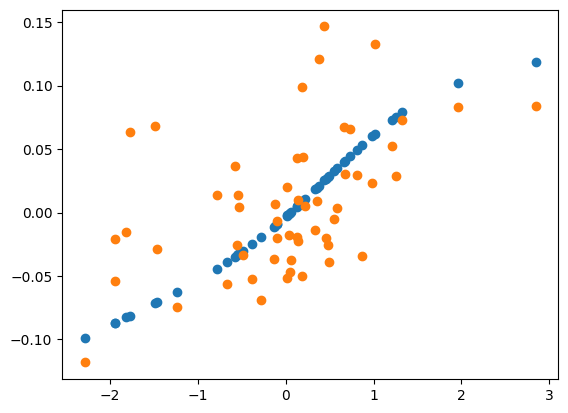

In [188]:
#plots predictions--remember, our model has never seen X_test
plt.scatter(X_test.detach().numpy(),y_preds.detach().numpy())

#plots test data
plt.scatter(X_test.detach().numpy(),y_test.detach().numpy())

## Part IV: Analysis

The model captures the **general trend** of high MKT being correlated to higher returns, as can be seen by the very linear-looking prediction curve. However, the data isn't as well fitted as it could be which makes sense since based on my previous project, MKT and Change have around an R^2 of 0.22. Overall, the model makes realistic sense (it shows the real world trend I'd expect), but this feels more like a manipulation of variables than an actual relationship, which I think is very typical of a nerual network.